In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import decimal
from decimal import Decimal

In [4]:
class Vehicle:
    # l = wheelbase [m] = 2.73
    # lp = distance from CG to front axle [m] = 1.2
    # lz = distance from CG to rear axle [m] = 1.53
    # m = mass of vehicle [kg] = 1700
    # g
    # Z_zst = normalna sila na zadna oska
    # Z_pst = normalna sila na predna oska
    # hc = visina na teziste [m] = 0.5
    # cd = drag coefficient [-] = 0.31
    # A = frontal area [m^2] = 2.71

    def __init__(self, l, lp, m, g, hc, cd, A):
        # setting vehicle parameters
        self.l = l
        self.lp = lp
        self.lz = l - lp
        self.m = m
        self.g = g
        self.Z_zst = m*g*lp/l
        self.Z_pst = m*g - self.Z_zst
        self.hc = hc
        self.cd = cd
        self.A = A

In [5]:
class Tire:
    # rd = tire radius [m] = 0.3
    # J = wheel inertia [kgm^2] = 8
    # fi = 0.8
    # a, b, c, d = Pacejka coefficients (1.0301, 16.6675, 0.05343, 65.1759)
    # f0 = 0.015

    def __init__(self, rd, J, fi, a, b, c, f0):
        self.rd = rd
        self.J = J
        self.fi = fi
        self.a = a
        self.b = b
        self.c = c
        self.f0 = f0

In [34]:
class Simulate:
    def __init__(self, Vehicle, Tire, tstep, simTime, torque):
        self.Vehicle = Vehicle
        self.Tire = Tire
        self.tstep = tstep
        self.simTime = simTime
        self.torque = torque

        # defining initial conditions
        self._current_x = 0 # prvicno pomestuvanje
        self._current_x_dot = 17 #prvicna brzina
        self._current_x_ddot = 0 # prvicno zabrzuvanje
        self._current_time = 0 # t0
        # self._initial_Fz = [9.81 * Vehicle.m * Vehicle.lp / Vehicle.l, 9.81 * Vehicle.m * Vehicle.lz / Vehicle.l] # [0] - predna oska, [1] - zadna oska
        self._current_Fz = [9.81 * Vehicle.m * Vehicle.lp / Vehicle.l, 9.81 * Vehicle.m * Vehicle.lz / Vehicle.l] # [0] - predna oska, [1] - zadna oska - staticki Zp i Zz
        self._current_Fx = [0, 0]
        self._current_slip = [0, 0] # predna i zadna oska
        self._current_omega = [self._current_x_dot / self.Tire.rd, self._current_x_dot / self.Tire.rd]
        self._current_torque = self.torque[0]

        self.counter = 0

        # output dataframe
        self.column_names = ['time [s]',
                            'x [m]',
                            'x_dot [m/s]',
                            'x_ddot [m/s^2]',
                            'Fz front [N]', 'Fz rear [N]',
                            'Fx front [N]', 'Fx rear [N]',
                            'Slip front [-]', 'Slip rear [-]',
                            'Front wheel speed [rad/s]', 'Rear wheel speed [rad/s]',
                            'Torque [Nm]']
        
        self.output = pd.DataFrame(columns = self.column_names)

    def updateValues(self, x, x_dot, x_ddot, time, Fz, Fx, slip, omega, torque):
        self._current_x = x
        self._current_x_dot = x_dot
        self._current_x_ddot = x_ddot
        self._current_time = time
        self._current_Fz = Fz
        self._current_Fx = Fx
        self._current_slip = slip
        self._current_omega = omega
        self._current_torque = torque


    def slip(self, omega, v_eig):
        if float(omega) * self.Tire.rd >= float(v_eig):
            slip = (float(omega) * self.Tire.rd - float(v_eig)) / (float(omega) * self.Tire.rd)
        else:
            slip = (float(omega) * self.Tire.rd - float(v_eig)) / float(v_eig)
        print('Slip = ' + str(round(slip, 2)))
        return slip

    def longitudinalForce(self, slip, normalForce):
        # mi = self.d * np.sin(self.c * np.arctan(self.b*slip - self.a * (self.b * slip - np.arctan(self.b * slip))))
        # mi = self.Tire.fi - self.Tire.fi * math.exp(-(self.Tire.a/self.Tire.fi) * (slip + self.Tire.b * slip**2)) - self.Tire.c*slip + self.Tire.d*slip**2
        mi = np.sign(slip) * ((self.Tire.a * (1 - math.exp(-self.Tire.b * abs(slip)))) - self.Tire.c * abs(slip))
        Fx = normalForce * mi
        return Fx

    def calcOmega(self, T, axle): # axle = 0 za predna, 1 za zadna oska
        slip = self.slip(self._current_omega[axle], self._current_x_dot)
        omega_dot = (T - self.Tire.rd * self.longitudinalForce(slip, self._current_Fz[axle])) / self.Tire.J
        omega = self._current_omega[axle] + omega_dot * self.tstep
        return omega

    def longDynamics(self):
        Fx = [0, 0]
        omega = [0, 0]
        slip = [0, 0]
        Fz = [0, 0]

        decimal.getcontext().prec = 100

        # otpor na vozduh
        try:
            Rv = (decimal.Decimal(self.Vehicle.cd) * decimal.Decimal(1.2) * decimal.Decimal(self.Vehicle.A) * decimal.Decimal(self._current_x_dot) ** 2) / decimal.Decimal(2)
        except OverflowError as err:
            print('Overflow on Rv, ', self._current_x_dot)


        # otpor na trkalanje
        try:
            Rf = (decimal.Decimal(self.Tire.f0) + decimal.Decimal(0.5) * decimal.Decimal(self._current_x_dot) ** 2 / 10**6) * decimal.Decimal(self.Vehicle.m) * decimal.Decimal(self.Vehicle.g)
        except OverflowError as err:
            print('Overflow on Rf', self._current_x_dot)

        

        # new omega
        for i in range(2):
            if i == 1: # zadno ima Tt = 0
                omega[i] = self.calcOmega(1, i)
            else:
                omega[i] = self.calcOmega(self._current_torque, i)
                print("Current torque: " + str(round(self._current_torque, 2)))

        # weight transfer
        Fz[0] = (-float(Rv) * self.Vehicle.hc - self._current_x_ddot * self.Vehicle.m * self.Vehicle.hc + self.Vehicle.m * 9.81 * self.Vehicle.lz) / self.Vehicle.l # predna oska
        Fz[1] = (float(Rv) * self.Vehicle.hc + self._current_x_ddot * self.Vehicle.m * self.Vehicle.hc + self.Vehicle.m * 9.81 * self.Vehicle.lp) / self.Vehicle.l # zadna oska

        for i in range(2):
            # slip[i] = self.slip(self._current_omega[i], self._current_x_dot) # presmetuva slip i predno i zadno
            slip[i] = self.slip(self._current_omega[i], self._current_x_dot)

        for i in range(2):
            # Fx[i] = self.longitudinalForce(slip[i], self._current_Fz[i]) # presmetuvam Fxp i Fxz
            Fx[i] = self.longitudinalForce(slip[i], Fz[i])


        # longitudinal acceleration
        x_ddot = (np.sum(Fx) - float(Rv) - float(Rf)) / self.Vehicle.m

        # new velocity
        x_dot = self._current_x_dot + x_ddot * self.tstep

        # new position
        x = self._current_x + x_dot * self.tstep
        time = self._current_time + self.tstep

        torque = self.torque[self.counter]

        self.counter = self.counter + 1

        return x, x_dot, x_ddot, time, Fz, Fx, slip, omega, torque

    def __calc__(self):
        for i in range(int(self.simTime/self.tstep)):
            current_values = self.longDynamics()
            self.updateValues(*current_values)
            output_data = [self._current_time,
                            self._current_x,
                            self._current_x_dot,
                            self._current_x_ddot,
                            self._current_Fz[0], self._current_Fz[1],
                            self._current_Fx[0], self._current_Fx[1],
                            self._current_slip[0], self._current_slip[1],
                            self._current_omega[0], self._current_omega[1],
                            self.torque]
            output = pd.DataFrame(np.array(output_data, dtype=object).reshape(-1, len(output_data)), columns=self.column_names)
            self.output = pd.concat([self.output, output], ignore_index=True)


In [7]:
# defining the vehicle
vehicle_obj = Vehicle(2.73, 1.2, 1700, 9.81, 0.5, 0.31, 2.71)
tire_obj = Tire(0.3, 8, 0.8, 1.11, 23.99, 0.52, 0.015)

In [8]:
# defining the torque input
Tt = []
for i in range(1000):
    Tt.append(i * 4)

In [9]:
# defining new torque input with sigmoid function
t_seg = np.arange(0, 2, 0.01).tolist()
sig_asc = []
for i in range(len(t_seg)):
    z = np.exp(-0.08*i+6)
    sig = 2000 / (1 + z)
    sig_asc.append(sig)

max_torque = []
for i in range(401):
    max_torque.append(2000)

Tt_sig = []
for i in range(400):
    Tt_sig.append(0)
# Tt_sig.append(sig_asc)
# Tt_sig.append(max_torque)

torque_final_curve = Tt_sig + sig_asc + max_torque

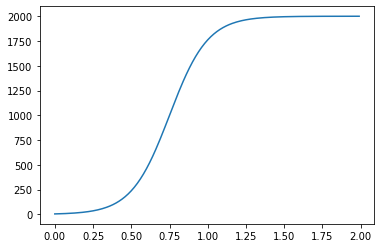

In [10]:
plt.plot(t_seg, sig_asc)

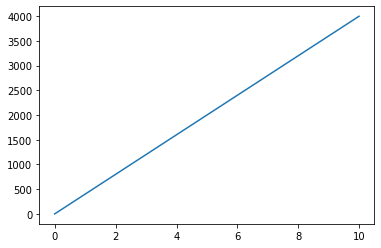

In [11]:
time_x = []
for t in range(1000):
    time_x.append(t*0.01)

plt.plot(time_x, Tt)
# print(time_x)

(0.0, 2010.0)

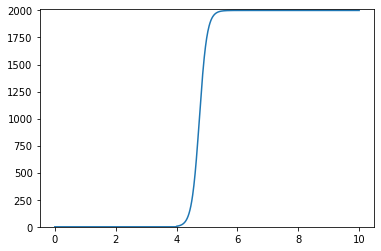

In [12]:
time_x2 = []
for t in range(1001):
    time_x2.append(t*0.01)

plt.plot(time_x2, torque_final_curve)
plt.ylim(top = 2010, bottom = 0)

In [35]:
# creating simulation object
sim = Simulate(vehicle_obj, tire_obj, 0.01, 10, torque_final_curve)

In [36]:
# running sim
sim.__calc__()

# getting output
data = sim.output

Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Current torque: 0
Slip = 0.0
Slip = 0.0
Slip = 0.0
Slip = 0

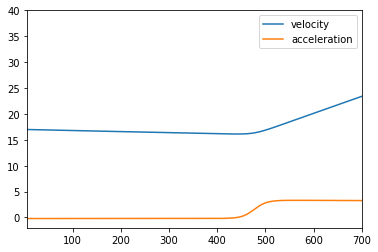

In [37]:
fig = plt.figure()

plt.plot(data['x_dot [m/s]'], label='velocity')
plt.plot(data['x_ddot [m/s^2]'], label='acceleration')
plt.xlim(left=5, right=700)
plt.ylim(top=40, bottom=-2)
plt.legend()

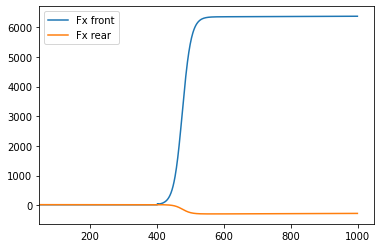

In [38]:
plt.plot(data['Fx front [N]'], label='Fx front')
plt.plot(data['Fx rear [N]'], label='Fx rear')
plt.xlim(left=50)
plt.legend()

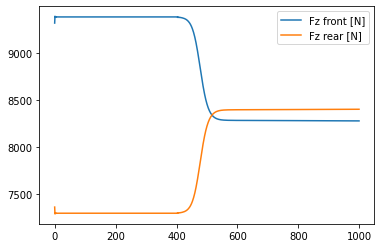

In [39]:
plt.plot(data['Fz front [N]'], label='Fz front [N]')
plt.plot(data['Fz rear [N]'], label='Fz rear [N]')
plt.legend()

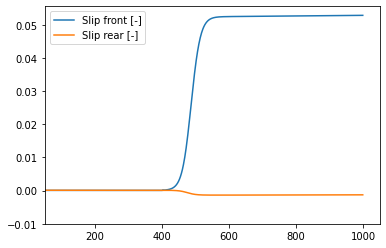

In [40]:
plt.plot(data['Slip front [-]'], label='Slip front [-]')
plt.plot(data['Slip rear [-]'], label='Slip rear [-]')
plt.xlim(left=50)
plt.ylim(bottom=-0.01)
plt.legend()

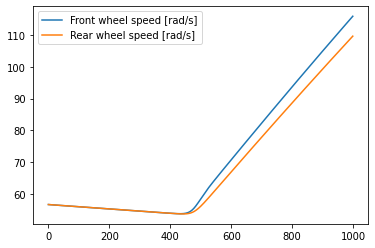

In [41]:
plt.plot(data['Front wheel speed [rad/s]'], label='Front wheel speed [rad/s]')
plt.plot(data['Rear wheel speed [rad/s]'], label='Rear wheel speed [rad/s]')
plt.legend()

In [23]:
s = np.arange(0, 1.01, 0.01).tolist()

In [24]:
a = 18
b = 8
c = 0.25
d = 0.11
fi = 0.8

mi = []
Fx = []
Fn = 10000 # [N]

for i in range(len(s)):
    mi.append(fi-fi*math.exp(-(a/fi)*(s[i]+b*s[i]**2)) - c*s[i]*np.sign(s[i]) + d*s[i]**2)
    Fx.append(mi[i]*Fn)

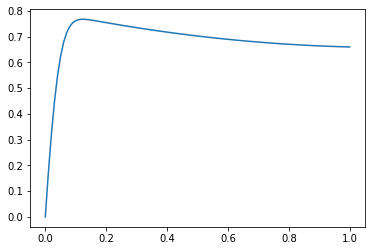

In [25]:
plt.plot(s, mi)

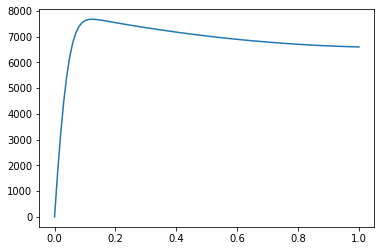

In [26]:
plt.plot(s, Fx)

In [27]:
s_neg = np.arange(-1, 1.01, 0.01).tolist()

In [30]:
koef_bh = [1.11, 23.99, 0.52]

mi_neg = []
Fx_neg = []
Fn = 10000 # [N]

for i in range(len(s_neg)):
    mi_novo = np.sign(s_neg[i]) * ((koef_bh[0] * (1 - math.exp(-koef_bh[1] * abs(s_neg[i])))) - koef_bh[2] * abs(s_neg[i]))
    mi_neg.append(mi_novo)
    Fx_neg.append(mi_neg[i]*Fn)

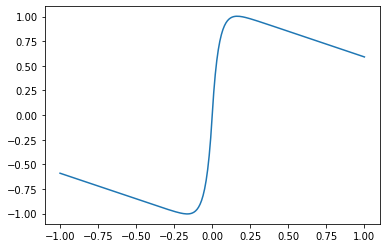

In [31]:
plt.plot(s_neg, mi_neg)